In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
!unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

In [ ]:
data=pd.read_csv("/content/Stress.csv")
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


## text processing

In [ ]:
stemmer=PorterStemmer()

## tokenization, filter stopwords, stemming

In [ ]:
def process_text(text):
    text=text.lower()
    text=re.sub("[^a-zA-Z!ñíá]"," ",str(text))
    text_wt=nltk.word_tokenize(text)
    text_sstopw=list(filter(lambda w: w not in stopwords, text_wt))
    text_stem=list(map(lambda w: stemmer.stem(w), text_sstopw))
    new_text=" ".join(text_stem)
    return new_text

In [ ]:
data["text_stem"]=data["text"].apply(lambda f: process_text(f))

In [ ]:
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,text_stem
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353,said felt way sugget go rest trigger ahead you...
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817,hey r assist sure right place post goe current...
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605,mom hit newspap shock would know like play hit...
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555,met new boyfriend amaz kind sweet good student...
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005,octob domest violenc awar month domest violenc...


In [ ]:
dat_stem=data[["text_stem", "label"]]
dat_stem.head()

,text_stem,label
0,said felt way sugget go rest trigger ahead you...,1
1,hey r assist sure right place post goe current...,0
2,mom hit newspap shock would know like play hit...,1
3,met new boyfriend amaz kind sweet good student...,1
4,octob domest violenc awar month domest violenc...,1


In [ ]:
list_text=list(dat_stem["text_stem"].values)
label=dat_stem["label"].values

## vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
max_features=2000

cou_vec=CountVectorizer(max_features=max_features, stop_words="english" , ngram_range=(1,2))

In [ ]:
matriz_text = cou_vec.fit_transform(list_text)

In [ ]:
pickle.dump(cou_vec,open('count_vectorization.pkl','wb'))

In [ ]:
x=matriz_text.toarray()
y=label

In [ ]:
print(x.shape)
print(y.shape)

(2838, 2000)
(2838,)


## data split. 80% for train, 20% for test

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

## support vector machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
model0 = SVC(kernel='rbf', gamma='auto', C=1)

In [ ]:
model0.fit(x_train, y_train)

SVC(C=1, gamma='auto')

In [ ]:
y_train_pred=model0.predict(x_train)
y_test_pred=model0.predict(x_test)
print(accuracy_score(y_train_pred, y_train))
print(accuracy_score(y_test_pred, y_test))

0.6229074889867842
0.6073943661971831


## data split. 90% for dev, 10% for held_out

In [ ]:
X_dev, X_held, y_dev, y_held=train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

## cross validate

In [ ]:
num=range(1,10) #(1,12)
train_scores_mean = []
train_scores_std = []
test_scores_mean = []
test_scores_std = []
for c in num:
    model0 = SVC(kernel='rbf', gamma='auto', C=c)
    scores = cross_validate(model0, X_dev, y_dev, cv=5, return_train_score=True, n_jobs = -1)
    train_scores_mean.append(scores['train_score'].mean())
    train_scores_std.append(scores['train_score'].std())

    test_scores_mean.append(scores['test_score'].mean())
    test_scores_std.append(scores['test_score'].std())

In [ ]:
Train_mn=np.array(train_scores_mean)
Train_st=np.array(train_scores_std)
Test_mn=np.array(test_scores_mean)
Test_st=np.array(test_scores_std)

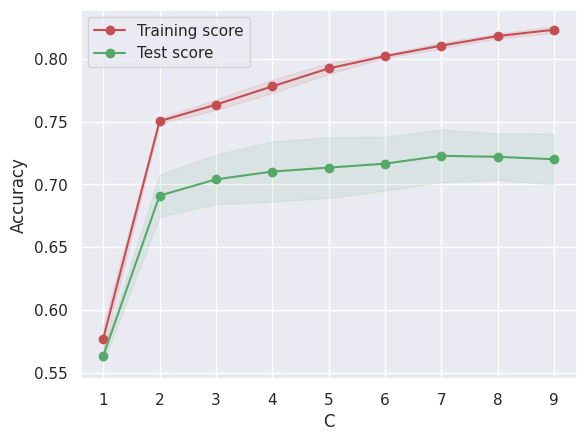

In [ ]:
plt.fill_between(num, Train_mn - Train_st,
                 Train_mn + Train_st, alpha=0.1,
                 color="r")
plt.fill_between(num, Test_mn - Test_st,
                 Test_mn + Test_st, alpha=0.1, color="g")

plt.plot(num, Train_mn, 'o-', color="r",
         label="Training score")
plt.plot(num, Test_mn, 'o-', color="g",
         label="Test score")


plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.show()

## put in production

In [ ]:
model=SVC(kernel='rbf', gamma='auto', C=7)

In [ ]:
model.fit(X_dev, y_dev)

SVC(C=7, gamma='auto')

In [ ]:
y_pred=model.predict(X_held)
accuracy_score(y_pred, y_held)

0.7816901408450704

In [ ]:
pickle.dump(model,open('svc_stress.pkl','wb'))